# Step 1: Import necessary libraries

In [1]:
import pyodbc
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Step 2: Load the dataset:

In [2]:
print(pyodbc.drivers())

['SQL Server', 'SQL Server Native Client 11.0', 'ODBC Driver 17 for SQL Server', 'Microsoft Access Driver (*.mdb, *.accdb)', 'Microsoft Excel Driver (*.xls, *.xlsx, *.xlsm, *.xlsb)', 'Microsoft Access Text Driver (*.txt, *.csv)', 'Microsoft Access dBASE Driver (*.dbf, *.ndx, *.mdx)']


In [ ]:
#to load data from azure cloud
""""
server = 
database =
username = 
password = 
driver =  

conn=pyodbc.connect( f'DRIVER={driver};SERVER={server};DATABASE={database};UID={username};PWD={password};Encrypt=yes;TrustServerCertificate=no;Connection Timeout=30;')
"""

#to load data from SQL
server = 'use server name'
database = 'database namr'

conn = pyodbc.connect(
    f'DRIVER={{SQL Server}};'
    f'SERVER={server};'
    f'DATABASE={database};'
    f'Trusted_Connection=yes;'
)

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score,StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,confusion_matrix,recall_score,precision_score,f1_score
from sklearn.impute import KNNImputer,SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier,VotingClassifier,StackingClassifier
import pickle as pkl
import warnings
warnings.filterwarnings("ignore")

In [5]:
q="""
SELECT  * from orders_Sales_return
"""

In [6]:
df=pd.read_sql(q, conn)

In [7]:
df.head()

,order_id,customer_id,customer_name,state_code,shipping_date,shipping_status,carrier,status,product_id,payment_method,category_id,reason,return_status,return_date,total_sales,quantity,is_active,percentage
0,NaN,NaN,,None,NaT,None,None,cancelled,NaN,None,NaN,None,None,NaT,NaN,NaN,None,NaN
1,11.0,1.0,Loretta Weaver,NV,2025-03-17 21:32:52,shipped,UPS,shipped,1.0,credit_card,8.0,None,None,NaT,1815.18,1.0,None,NaN
2,55.0,5.0,Sheila Cohen,AS,2025-02-21 20:37:26,delivered,FedEx,cancelled,1.0,bank_transfer,8.0,None,None,NaT,1815.18,3.0,None,NaN
3,55.0,5.0,Sheila Cohen,AS,2025-02-21 20:37:26,delivered,FedEx,delivered,1.0,bank_transfer,8.0,None,None,NaT,5445.54,3.0,None,NaN
4,55.0,5.0,Sheila Cohen,AS,2025-02-21 20:37:26,delivered,FedEx,pending,1.0,bank_transfer,8.0,None,None,NaT,1815.18,3.0,None,NaN


In [8]:
df = df[df['return_status'].notna()]

In [9]:
df.shape

(1623, 18)

In [10]:
df.duplicated().sum()

85

In [11]:
df.drop_duplicates(inplace=True)

In [12]:
df.duplicated().sum()

0

In [13]:
df.head()

,order_id,customer_id,customer_name,state_code,shipping_date,shipping_status,carrier,status,product_id,payment_method,category_id,reason,return_status,return_date,total_sales,quantity,is_active,percentage
714,47.0,38.0,Edwin Castro,TN,2025-02-14 16:37:24,delivered,DHL,delivered,45.0,paypal,6.0,Wrong size,approved,2025-03-05 16:37:24,1405.56,4.0,None,NaN
715,47.0,38.0,Edwin Castro,TN,2025-02-14 16:37:24,delivered,DHL,processing,45.0,paypal,6.0,Wrong size,approved,2025-03-05 16:37:24,1405.56,4.0,None,NaN
907,47.0,38.0,Edwin Castro,TN,2025-02-14 16:37:24,delivered,DHL,delivered,57.0,paypal,8.0,Wrong size,approved,2025-03-05 16:37:24,597.38,1.0,None,NaN
908,47.0,38.0,Edwin Castro,TN,2025-02-14 16:37:24,delivered,DHL,processing,57.0,paypal,8.0,Wrong size,approved,2025-03-05 16:37:24,597.38,1.0,None,NaN
939,47.0,38.0,Edwin Castro,TN,2025-02-14 16:37:24,delivered,DHL,delivered,58.0,paypal,4.0,Wrong size,approved,2025-03-05 16:37:24,2611.35,5.0,None,NaN


In [14]:
df.drop(['order_id','customer_id','customer_name','product_id','category_id','reason'],axis=1,inplace=True)

In [15]:
df.sample(5)

,state_code,shipping_date,shipping_status,carrier,status,payment_method,return_status,return_date,total_sales,quantity,is_active,percentage
43580,AS,2025-02-01 01:57:18,delivered,FedEx,delivered,bank_transfer,approved,2025-02-02 01:57:18,6023.20,4.0,None,NaN
73186,ID,2025-01-29 07:25:12,delivered,UPS,shipped,credit_card,completed,2025-01-29 07:25:12,1832.40,1.0,None,NaN
88447,OK,2025-03-05 07:06:03,delivered,DHL,cancelled,bank_transfer,completed,2025-03-07 07:06:03,2833.53,3.0,True,0.4512
2608,Unit,2025-03-17 12:22:28,delivered,DHL,processing,credit_card,approved,2025-04-07 12:22:28,12414.96,4.0,True,0.3078
9837,USNV,2025-03-25 13:57:05,delivered,DHL,cancelled,credit_card,rejected,2025-04-12 13:57:05,12051.72,4.0,True,0.3078


In [16]:
df.isna().sum()

state_code            0
shipping_date         0
shipping_status       0
carrier               0
status                0
payment_method        0
return_status         0
return_date           0
total_sales           0
quantity              0
is_active          1243
percentage         1243
dtype: int64

In [17]:
df.percentage.value_counts()

percentage
0.3078    135
0.3660     90
0.4512     45
0.1879     10
0.4612      5
0.2737      5
0.2078      5
Name: count, dtype: int64

In [18]:
df.is_active.value_counts()

is_active
True    295
Name: count, dtype: int64

In [19]:
df['percentage']=df['percentage'].fillna(value=0)
df.percentage.value_counts()

percentage
0.0000    1243
0.3078     135
0.3660      90
0.4512      45
0.1879      10
0.4612       5
0.2737       5
0.2078       5
Name: count, dtype: int64

In [20]:
df['is_active']=df['is_active'].fillna(value=False)
df.is_active.value_counts()

is_active
False    1243
True      295
Name: count, dtype: int64

In [21]:
df.shape

(1538, 12)

In [22]:
df.head()

,state_code,shipping_date,shipping_status,carrier,status,payment_method,return_status,return_date,total_sales,quantity,is_active,percentage
714,TN,2025-02-14 16:37:24,delivered,DHL,delivered,paypal,approved,2025-03-05 16:37:24,1405.56,4.0,False,0.0
715,TN,2025-02-14 16:37:24,delivered,DHL,processing,paypal,approved,2025-03-05 16:37:24,1405.56,4.0,False,0.0
907,TN,2025-02-14 16:37:24,delivered,DHL,delivered,paypal,approved,2025-03-05 16:37:24,597.38,1.0,False,0.0
908,TN,2025-02-14 16:37:24,delivered,DHL,processing,paypal,approved,2025-03-05 16:37:24,597.38,1.0,False,0.0
939,TN,2025-02-14 16:37:24,delivered,DHL,delivered,paypal,approved,2025-03-05 16:37:24,2611.35,5.0,False,0.0


In [23]:
df['shipping_date'] = pd.to_datetime(df['shipping_date'])
df['return_date'] = pd.to_datetime(df['return_date'])

In [24]:
df['return_days'] = (df['return_date'] - df['shipping_date']).dt.days

df['shipping_month'] = df['shipping_date'].dt.month

In [25]:
df.head()

,state_code,shipping_date,shipping_status,carrier,status,payment_method,return_status,return_date,total_sales,quantity,is_active,percentage,return_days,shipping_month
714,TN,2025-02-14 16:37:24,delivered,DHL,delivered,paypal,approved,2025-03-05 16:37:24,1405.56,4.0,False,0.0,19,2
715,TN,2025-02-14 16:37:24,delivered,DHL,processing,paypal,approved,2025-03-05 16:37:24,1405.56,4.0,False,0.0,19,2
907,TN,2025-02-14 16:37:24,delivered,DHL,delivered,paypal,approved,2025-03-05 16:37:24,597.38,1.0,False,0.0,19,2
908,TN,2025-02-14 16:37:24,delivered,DHL,processing,paypal,approved,2025-03-05 16:37:24,597.38,1.0,False,0.0,19,2
939,TN,2025-02-14 16:37:24,delivered,DHL,delivered,paypal,approved,2025-03-05 16:37:24,2611.35,5.0,False,0.0,19,2


In [26]:
df.drop(['shipping_date', 'return_date'], axis=1, inplace=True)
df.head()

,state_code,shipping_status,carrier,status,payment_method,return_status,total_sales,quantity,is_active,percentage,return_days,shipping_month
714,TN,delivered,DHL,delivered,paypal,approved,1405.56,4.0,False,0.0,19,2
715,TN,delivered,DHL,processing,paypal,approved,1405.56,4.0,False,0.0,19,2
907,TN,delivered,DHL,delivered,paypal,approved,597.38,1.0,False,0.0,19,2
908,TN,delivered,DHL,processing,paypal,approved,597.38,1.0,False,0.0,19,2
939,TN,delivered,DHL,delivered,paypal,approved,2611.35,5.0,False,0.0,19,2


In [27]:
# Encoding

cat_cols = ['state_code', 'shipping_status', 'carrier', 'status', 'payment_method', 'return_status']
le = LabelEncoder()
for col in cat_cols:
    df[col] = le.fit_transform(df[col])

df.head()

,state_code,shipping_status,carrier,status,payment_method,return_status,total_sales,quantity,is_active,percentage,return_days,shipping_month
714,35,0,0,1,2,0,1405.56,4.0,False,0.0,19,2
715,35,0,0,3,2,0,1405.56,4.0,False,0.0,19,2
907,35,0,0,1,2,0,597.38,1.0,False,0.0,19,2
908,35,0,0,3,2,0,597.38,1.0,False,0.0,19,2
939,35,0,0,1,2,0,2611.35,5.0,False,0.0,19,2


In [28]:
df.isna().sum()

state_code         0
shipping_status    0
carrier            0
status             0
payment_method     0
return_status      0
total_sales        0
quantity           0
is_active          0
percentage         0
return_days        0
shipping_month     0
dtype: int64

In [29]:
for col in df.columns:
    print(df[col].value_counts())
    print('*'*50)

state_code
13    205
34     90
12     80
4      65
11     55
32     50
3      50
22     50
29     50
41     50
42     45
30     45
21     40
16     40
9      40
0      40
17     40
15     35
37     35
23     30
40     30
36     30
26     25
38     25
43     25
31     25
14     20
28     20
19     20
39     20
27     20
24     15
6      15
10     15
2      15
20     10
44     10
45     10
33     10
5      10
35      8
7       5
1       5
18      5
8       5
25      5
Name: count, dtype: int64
**************************************************
shipping_status
0    1538
Name: count, dtype: int64
**************************************************
carrier
0    623
2    525
1    390
Name: count, dtype: int64
**************************************************
status
1    310
3    310
0    306
2    306
4    306
Name: count, dtype: int64
**************************************************
payment_method
0    540
1    530
2    468
Name: count, dtype: int64
****************************************

In [30]:
df.drop('shipping_status',axis=1,inplace=True)
df.head()

,state_code,carrier,status,payment_method,return_status,total_sales,quantity,is_active,percentage,return_days,shipping_month
714,35,0,1,2,0,1405.56,4.0,False,0.0,19,2
715,35,0,3,2,0,1405.56,4.0,False,0.0,19,2
907,35,0,1,2,0,597.38,1.0,False,0.0,19,2
908,35,0,3,2,0,597.38,1.0,False,0.0,19,2
939,35,0,1,2,0,2611.35,5.0,False,0.0,19,2


In [31]:
X = df.drop('return_status', axis=1)
y = df['return_status']

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [33]:
Accuracy_models=[]
f1_score_models=[]
precision_scores=[]
recall_scores=[]
Models_names=[]

In [34]:
def evaluate_model_performance(model, x_train, x_test, y_train, y_test):
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)


    Train_accuracy = accuracy_score(y_train, y_train_pred)
    Test_accuracy = accuracy_score(y_test, y_test_pred)
    test_recall_score = recall_score(y_test, y_test_pred, average='macro')
    test_f1_score = f1_score(y_test, y_test_pred, average='macro')
    precision_score_test = precision_score(y_test, y_test_pred, average='macro')


    print(f"- Train Accuracy: {Train_accuracy*100:.2f}%")
    print(f"- Test Accuracy: {Test_accuracy*100:.2f}%")
    print(f"- F1 Score: {test_f1_score*100:.2f}%")
    print(f"- Precision: {precision_score_test*100:.2f}%")
    print(f"- Recall: {test_recall_score*100:.2f}%\n")


    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    
    Accuracy_models.append(Test_accuracy)
    f1_score_models.append(test_f1_score)
    precision_scores.append(precision_score_test)
    recall_scores.append(test_recall_score)


# Decision Tree

In [35]:
decision_tree = DecisionTreeClassifier(random_state=42)
params={'criterion':['gini', 'entropy','log_loss'], 'max_depth':[5, 6, 7, 8,9, 10, 11, 12],'ccp_alpha':[0.001, 0.01, 0.02, 0.03]}

grid_dt=GridSearchCV(estimator=decision_tree,
                  param_grid=params,
                  cv=5,
                  scoring='accuracy')

grid_dt.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'ccp_alpha': [0.001, 0.01, 0.02, 0.03],
                         'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [5, 6, 7, 8, 9, 10, 11, 12]},
             scoring='accuracy')

In [36]:
finall_decision_tree=grid_dt.best_estimator_
grid_dt.best_params_

{'ccp_alpha': 0.001, 'criterion': 'entropy', 'max_depth': 12}

- Train Accuracy: 98.62%
- Test Accuracy: 97.40%
- F1 Score: 97.67%
- Precision: 97.44%
- Recall: 98.11%



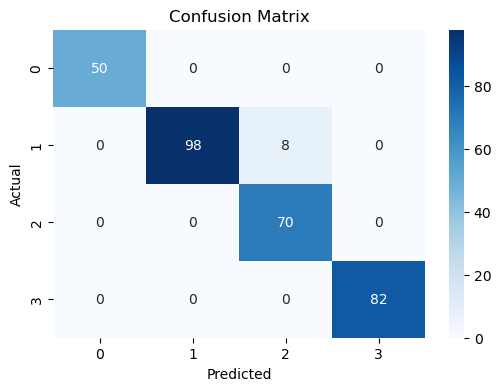

In [37]:
evaluate_model_performance(finall_decision_tree,X_train,X_test,y_train,y_test)

# StandardScaler

In [38]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# SVC

In [39]:
svc = SVC()

param_grid = {'C': [0.01, 0.1, 1, 10, 20], 'kernel': ['linear', 'rbf'], 'gamma': ['scale', 'auto']}

grid_svc = GridSearchCV(estimator=svc,
                               param_grid=param_grid,
                               cv=5,
                               scoring='accuracy')

grid_svc.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.01, 0.1, 1, 10, 20],
                         'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf']},
             scoring='accuracy')

In [40]:
finall_svc = grid_svc.best_estimator_
grid_svc.best_params_

{'C': 20, 'gamma': 'scale', 'kernel': 'rbf'}

- Train Accuracy: 98.54%
- Test Accuracy: 93.51%
- F1 Score: 93.43%
- Precision: 93.06%
- Recall: 94.09%



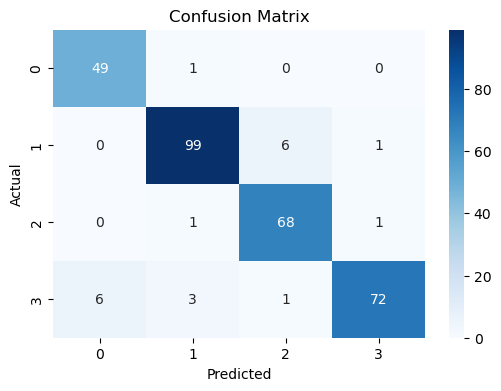

In [41]:
evaluate_model_performance(finall_svc, X_train, X_test, y_train, y_test)

# KNN

In [42]:
# knn=KNeighborsClassifier(n_neighbors=12,p=2)
# knn.fit(X_train,y_train)

In [43]:
# evaluate_model_performance(knn,X_train,X_test,y_train,y_test)

In [44]:
knn = KNeighborsClassifier()

param_grid_knn = { 'n_neighbors': [3, 5, 7, 9],'weights': ['uniform', 'distance'], 'metric': ['euclidean', 'manhattan']}

grid_knn = GridSearchCV(estimator=knn,
                               param_grid=param_grid_knn,
                               cv=3,
                               scoring='accuracy')

grid_knn.fit(X_train, y_train)


GridSearchCV(cv=3, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [3, 5, 7, 9],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [45]:
finall_knn = grid_knn.best_estimator_
grid_knn.best_params_

{'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}

- Train Accuracy: 100.00%
- Test Accuracy: 95.13%
- F1 Score: 94.80%
- Precision: 94.38%
- Recall: 95.53%



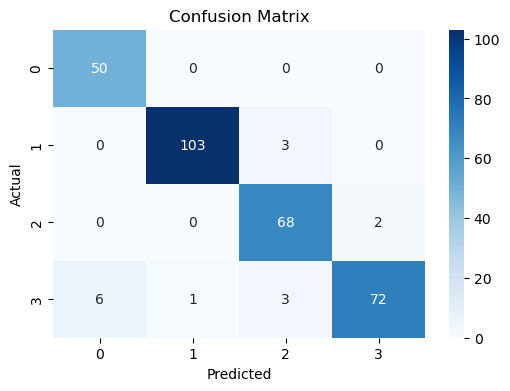

In [46]:
evaluate_model_performance(finall_knn, X_train, X_test, y_train, y_test)

# XGBoost

In [47]:
xgboost = XGBClassifier( n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42)
xgboost.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)

- Train Accuracy: 98.29%
- Test Accuracy: 98.70%
- F1 Score: 98.81%
- Precision: 98.75%
- Recall: 98.87%



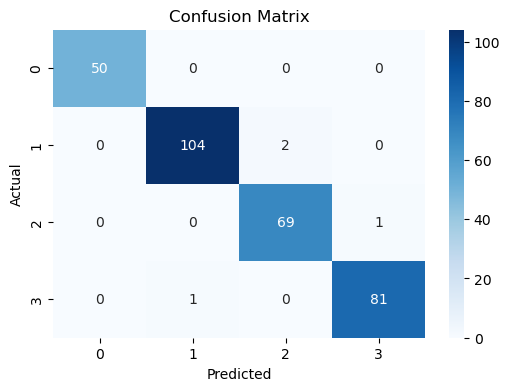

In [48]:
evaluate_model_performance(xgboost,X_train,X_test,y_train,y_test)

# AdaBoost

In [49]:
adaboost=AdaBoostClassifier(DecisionTreeClassifier(max_depth=3),
                            n_estimators=100,
                            learning_rate=0.1,
                            random_state=42)
adaboost.fit(X_train,y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3),
                   learning_rate=0.1, n_estimators=100, random_state=42)

- Train Accuracy: 97.15%
- Test Accuracy: 97.73%
- F1 Score: 97.55%
- Precision: 96.97%
- Recall: 98.35%



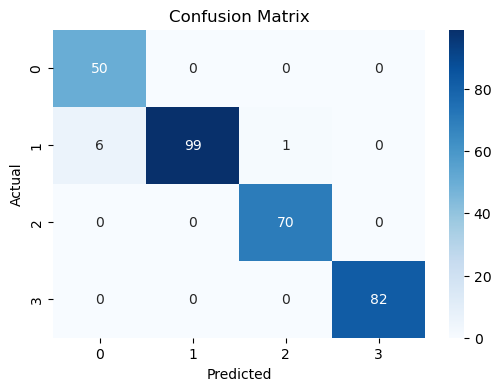

In [50]:
evaluate_model_performance(adaboost,X_train,X_test,y_train,y_test)

In [51]:
for name in ['Decision Tree', 'SVC', 'KNN', 'XGBoost', 'AdaBoost']:
    Models_names.append(name)

In [52]:
print(Models_names)
print(Accuracy_models)
print(f1_score_models)
print(precision_scores)

['Decision Tree', 'SVC', 'KNN', 'XGBoost', 'AdaBoost']
[0.974025974025974, 0.935064935064935, 0.9512987012987013, 0.987012987012987, 0.9772727272727273]
[0.9766825649178591, 0.9342996084375395, 0.9479674937222107, 0.9880775682063566, 0.9755394215925299]
[0.9743589743589743, 0.9306179518679518, 0.9437834125334126, 0.987528013610116, 0.9696931589537223]


In [53]:
model_accuracy=pd.DataFrame({ 'Model':Models_names,'Accuracy':Accuracy_models,'Precision':precision_scores,'F1_Score':f1_score_models,'Recall':recall_scores }).sort_values(by='Accuracy',ascending=False)
model_accuracy.reset_index(inplace=True,drop=True)
model_accuracy

,Model,Accuracy,Precision,F1_Score,Recall
0,XGBoost,0.987013,0.987528,0.988078,0.988663
1,AdaBoost,0.977273,0.969693,0.975539,0.983491
2,Decision Tree,0.974026,0.974359,0.976683,0.981132
3,KNN,0.951299,0.943783,0.947967,0.955294
4,SVC,0.935065,0.930618,0.934300,0.940860


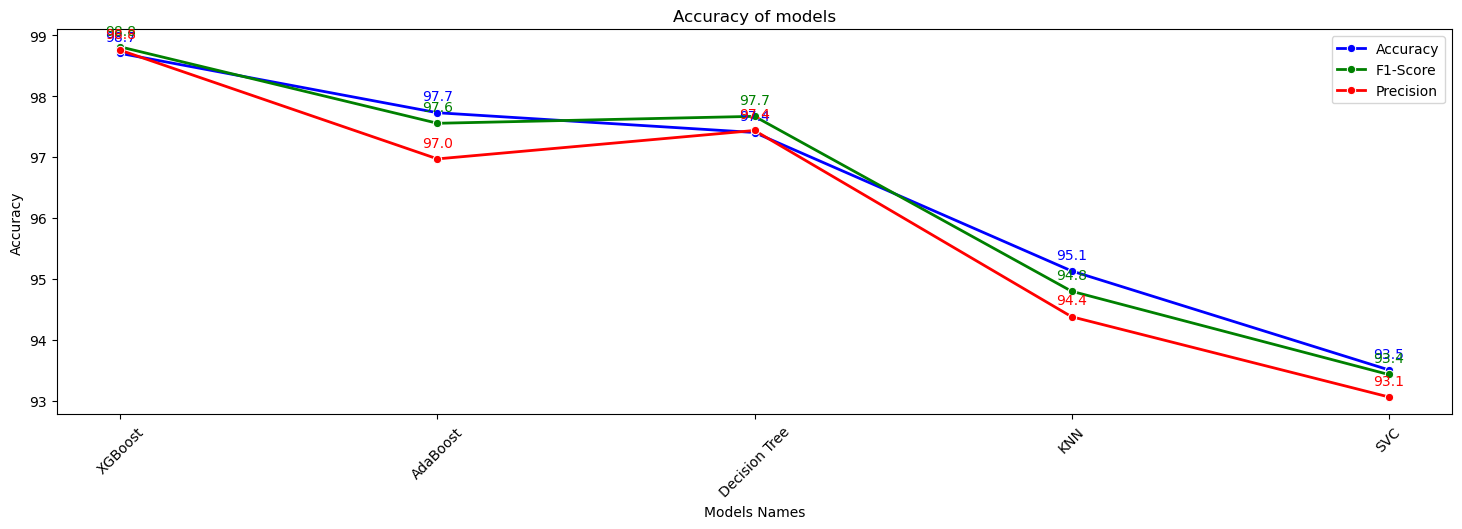

In [54]:
plt.figure(figsize=(18,5))

sns.lineplot(x=model_accuracy['Model'], y=model_accuracy['Accuracy']*100, marker='o', color='b', lw=2, label='Accuracy')
for i, score in enumerate(model_accuracy['Accuracy']):
    plt.text(i, score*100 + 0.2, f'{score*100:.1f}', ha='center', color='b')

sns.lineplot(x=model_accuracy['Model'],y=model_accuracy['F1_Score']*100,marker='o',color='g',lw=2,label='F1-Score')
for i, score in enumerate(model_accuracy['F1_Score']):
    plt.text(i, score*100 + 0.2, f'{score*100:.1f}', ha='center', color='g')

sns.lineplot(x=model_accuracy['Model'],y=model_accuracy['Precision']*100,marker='o',color='r',lw=2,label='Precision')
for i, score in enumerate(model_accuracy['Precision']):
    plt.text(i, score*100 + 0.2, f'{score*100:.1f}', ha='center', color='r')


plt.legend()
plt.xticks(rotation=45)

plt.xlabel('Models Names')
plt.ylabel('Accuracy')
plt.title('Accuracy of models')
plt.show()

In [56]:
# models=[finall_decision_tree, finall_svc, finall_knn, xgboost, adaboost]
# for model,name in zip(models,Models_names):
#     pkl.dump(model,open(f"D:\\Files\\3D Objects\\models_bootcamp\\{name}.pkl",'wb'))